<span style="font-size: 14pt">YEREVAN, May-June 2017</span>

<span style="font-size: 16pt"> HW #5: Compositions of time series forecasting algorithms

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>


<h1 align="center"> Home Work 5 </h1>
** Realize following composions for adaptive algorithms (ESM): Adaptive Selection and Adaptive Composition.**

Start with the code below

In [4]:
def AdaptiveExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = np.NaN
    t0= np.NaN
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
                e1=alpha
                e2 = 1
            else:
                if (t-t0)<h:
                    e1 = gamma*(x[t]-y)+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-y)+(1-gamma)*e2
                else:
                    e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            
            if e2==0:
                K=alpha
            else:
                K=np.abs(e1/e2)

            alpha=Kt_1
            Kt_1=K

            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y
    return FORECAST


def SimpleExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(y):
                y=x[cntr]
            y = y*(1-alpha) + alpha*x[cntr]
            #else do not nothing
        FORECAST[cntr+h] = y
    return FORECAST

In [5]:
def qualityRMSE(x,y):
    # Root mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (((x-y)**2).mean())**(0.5) , (x-y)**2
def qualityMedianAE(x,y):
    # Median absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y).abs()).median(), (x-y).abs()

In [136]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta

%matplotlib inline

In [201]:
def AdaptiveSelection(x, h, Params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    Params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        eps <scalar> - bound for best indistinctive models
        BaseAlgs - array of <dict> with params
            BaseAlg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    x = np.nan_to_num(x)
    T = len(x)
    FORECAST = [np.NaN]*(T+h)
    # Base Algs Forecasts     
    BaseAlgs = Params['BaseAlgsParams']
    N = len(BaseAlgs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    #forecast TS by each base algs
    #be careful with eval() function    
    for ba in range(len(BaseAlgs)):
        FORECAST_BA[ba]= eval(BaseAlgs[ba]['BaseAlg']+"(x,h,"+"BaseAlgs["+str(ba)+"]['BaseAlgParams'])")
        
    #internal params of composition
    gamma = Params['gamma']
    eps = Params['eps']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= [0]*N  # initialization of errors of base algorithms 
    j_best = [0]*N
    y = 0
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                for index,key in enumerate(FORECAST_BA):
                    e1[index] = gamma*np.abs(x[t]-key.transpose()[t])+(1-gamma)*e1[index]

                j_best = np.argmin(e1)
                idx_bestinsdistinctive = []
                # select best indistinctive 
                for index, error in enumerate(e1):
                    if abs(error - e1[j_best]) < eps:
                        idx_bestinsdistinctive.append(index)
                y = FORECAST_BA[idx_bestinsdistinctive][:,t].mean()
        FORECAST[t+h] = y
    return FORECAST

In [210]:
def AdaptiveCombination(x, h, Params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    Params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        BaseAlgs - array of <dict> with params
            BaseAlg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    x = np.nan_to_num(x)
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # Base Algs Forecasts     
    BaseAlgs = Params['BaseAlgsParams']
    N = len(BaseAlgs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(BaseAlgs)):
        FORECAST_BA[ba]= eval(BaseAlgs[ba]['BaseAlg']+"(x,h,"+"BaseAlgs["+str(ba)+"]['BaseAlgParams'])")
    
    # internal params of composition
    gamma = Params['gamma']

    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= [0]*N  # initialization of errors of base algorithms 
    weights = [0]*N
    y = 0
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                for index,key in enumerate(FORECAST_BA):
                    e1[index] = gamma*np.abs(x[t]-key.transpose()[t])+(1-gamma)*e1[index]

                w = np.ones(len(FORECAST_BA))
                sum_err = 0.0
                for index, error in enumerate(e1):
                    if error != 0: 
                        sum_err+=float(1.0/error)
                    else:
                        sum_err = 1

                for index, error in enumerate(e1):
                    if error!=0:
                        w[index] = (1/error)/sum_err
                    else:
                        w[index] = 1/len(FORECAST_BA)
                y = 0
                for index, wage in enumerate(w):
                    y += wage * FORECAST_BA[index][t]
            
        FORECAST[t+h] = y
    return FORECAST

In [145]:
BaseAlgs = [{'BaseAlg':'SimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.1}},
            {'BaseAlg':'SimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.2}},
            {'BaseAlg':'SimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.3}},
            {'BaseAlg':'SimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.4}},
            {'BaseAlg':'SimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.5}},
            {'BaseAlg':'AdaptiveExponentialSmoothing', 'BaseAlgParams':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}},
            {'BaseAlg':'AdaptiveExponentialSmoothing', 'BaseAlgParams':{'alpha':0.1,'gamma':0.03, 'AdaptationPeriod':10}},
            {'BaseAlg':'AdaptiveExponentialSmoothing', 'BaseAlgParams':{'alpha':0.3,'gamma':0.01, 'AdaptationPeriod':10}},
            {'BaseAlg':'AdaptiveExponentialSmoothing', 'BaseAlgParams':{'alpha':0.15,'gamma':0.01, 'AdaptationPeriod':10}},
            {'BaseAlg':'AdaptiveExponentialSmoothing', 'BaseAlgParams':{'alpha':0.25,'gamma':0.04, 'AdaptationPeriod':10}},
#                  {'BaseAlg':'AdaptiveSimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.1, 'gamma':0.01}},
#                 {'BaseAlg':'TheilWageSmoothing', 'BaseAlgParams':{'alpha':0.3, 'beta':0.9,'delta':0.9}}
]

In [215]:
for ba in range(len(BaseAlgs)):
    print(BaseAlgs[ba]['BaseAlg']+"(x,h,"+"BaseAlgs["+str(ba)+"]['BaseAlgsParams'])")

SimpleExponentialSmoothing(x,h,BaseAlgs[0]['BaseAlgsParams'])
SimpleExponentialSmoothing(x,h,BaseAlgs[1]['BaseAlgsParams'])
SimpleExponentialSmoothing(x,h,BaseAlgs[2]['BaseAlgsParams'])
SimpleExponentialSmoothing(x,h,BaseAlgs[3]['BaseAlgsParams'])
SimpleExponentialSmoothing(x,h,BaseAlgs[4]['BaseAlgsParams'])
AdaptiveExponentialSmoothing(x,h,BaseAlgs[5]['BaseAlgsParams'])
AdaptiveExponentialSmoothing(x,h,BaseAlgs[6]['BaseAlgsParams'])
AdaptiveExponentialSmoothing(x,h,BaseAlgs[7]['BaseAlgsParams'])
AdaptiveExponentialSmoothing(x,h,BaseAlgs[8]['BaseAlgsParams'])
AdaptiveExponentialSmoothing(x,h,BaseAlgs[9]['BaseAlgsParams'])


In [277]:
ts = pd.read_csv('./TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
# ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.')
ts = ts.sort_index() # sort index

In [278]:
h =1 
frc_ts_0 = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                      , columns = ts.columns)
frc_ts_1 = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                      , columns = ts.columns)
FRC_TS = dict()

In [279]:
# run Adaptive Selection
gamma=0.01
eps = 0.01

for cntr in ts.columns:
    frc_ts_0[cntr]= AdaptiveSelection(ts[cntr],h, {'gamma':gamma, 'eps': eps, 'BaseAlgsParams':BaseAlgs})
FRC_TS['AS gamma %.2f eps %.2f' % (gamma, eps)] = frc_ts_0

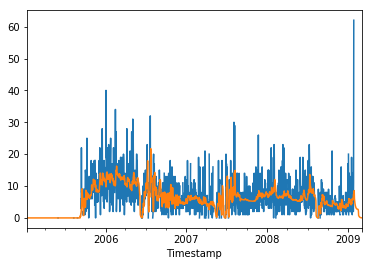

In [283]:
ts['Item: 2765'].plot()
frc_ts_0['Item: 2765'].plot()

In [281]:
# run Adaptive Composition
gamma=0.01

for cntr in ts.columns:
    frc_ts_1[cntr]= AdaptiveCombination(ts[cntr],h, {'gamma':gamma, 'BaseAlgsParams':BaseAlgs})
FRC_TS['AC gamma %.2f' % (gamma)] = frc_ts_1

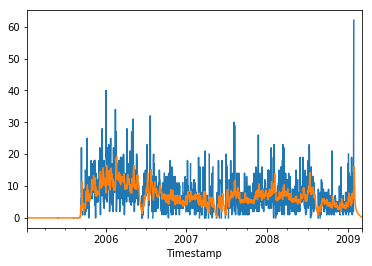

In [284]:
ts['Item: 2765'].plot()
frc_ts_1['Item: 2765'].plot()

In [262]:
# FRC_TS

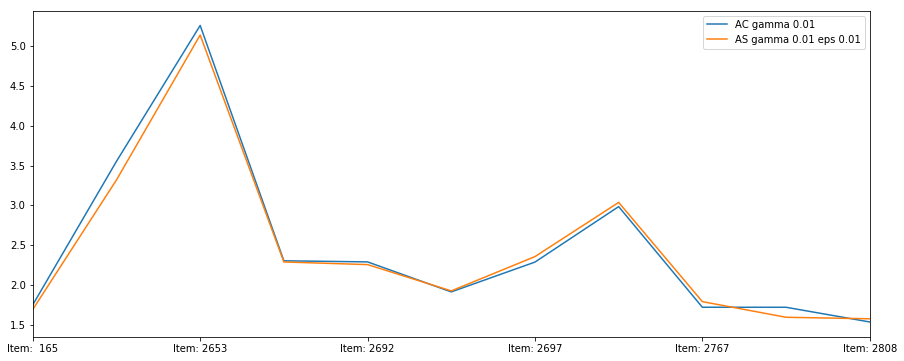

In [293]:
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in QualityStr.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        QualityStr[model][ts_num],_ = qualityMedianAE(ts[ts_num], frc_ts[ts_num])

QualityStr.plot(figsize = (15,6))